In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import xgboost
import lightgbm
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR,LinearSVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings("ignore")


In [312]:
data=pd.read_excel("./Data.xlsx",sheet_name=0)
test_data=pd.read_excel("./Data.xlsx",sheet_name=1)

In [313]:
#preprocessing for HS and Avg
def high_score_process(data):
    data['HS_out']=data['HS'].apply(lambda x :1 if isinstance(x, str) else 0)
    data['HS']=data['HS'].apply(lambda x :int(x[:-1]) if isinstance(x, str) else x)
    data['Avg']=data['Avg'].apply(lambda x:float(x) if not isinstance(x, str) else 0)
    return data
data=high_score_process(data)
test_data=high_score_process(test_data)

In [199]:
data.head()

,PLAYER,Mat,Inns,NO,2018_Runs,HS,Avg,BF,SR,100,50,4s,6s,2019_Runs,HS_out
0,Aaron Finch,10,9,1,134,46,16.75,100,134.00,0,0,6,8,160,0
1,AB de Villiers,12,11,2,480,90,53.33,275,174.54,0,6,39,30,424,1
2,Abhishek Sharma,3,3,2,63,46,63.00,33,190.90,0,0,3,5,63,1
3,Ajinkya Rahane,15,14,1,370,65,28.46,313,118.21,0,1,39,5,396,1
4,Alex Hales,6,6,0,148,45,24.66,118,125.42,0,0,13,6,165,0


In [200]:
#basic funtion to train and get metrics of various models
def get_results(train_x,train_y,dev_x,dev_y):
    
    model=LinearRegression()
    model.fit(train_x,train_y)
    model.score(dev_x,dev_y)
    print("Linear Regression : ",r2_score(dev_y,model.predict(dev_x)),mean_absolute_error(dev_y,model.predict(dev_x)),mean_squared_error(dev_y,model.predict(dev_x)))
    print()
    
    model=RandomForestRegressor()
    model.fit(train_x,train_y)
    model.score(dev_x,dev_y)
    print("Random Forest Regression : ",r2_score(dev_y,model.predict(dev_x)),mean_absolute_error(dev_y,model.predict(dev_x)),mean_squared_error(dev_y,model.predict(dev_x)))
    print()
    
    model=SVR(C=10000,gamma='scale')
    model.fit(train_x,train_y)
    print("SVM Regression : ",r2_score(dev_y,model.predict(dev_x)),mean_absolute_error(dev_y,model.predict(dev_x)),mean_squared_error(dev_y,model.predict(dev_x)))
    print()
    
    model=LinearSVR(C=1000,max_iter=10000)
    model.fit(train_x,train_y)
    print("LinearSVR Regression : ",r2_score(dev_y,model.predict(dev_x)),mean_absolute_error(dev_y,model.predict(dev_x)),mean_squared_error(dev_y,model.predict(dev_x)))
    print()
    
    model=xgboost.XGBRegressor(n_estimators=10000)
    model.fit(train_x,train_y)
    print("XGBoost Regression : ",r2_score(dev_y,model.predict(dev_x)),mean_absolute_error(dev_y,model.predict(dev_x)),mean_squared_error(dev_y,model.predict(dev_x)))
    print()
    
    model=lightgbm.LGBMRegressor(n_estimators=10000,learning_rate=0.001)
    model.fit(train_x,train_y)
    print("Light gbm Regression : ",r2_score(dev_y,model.predict(dev_x)),mean_absolute_error(dev_y,model.predict(dev_x)),mean_squared_error(dev_y,model.predict(dev_x)))
    print()
    
    
    
train_x,dev_x,train_y,dev_y=train_test_split(data.drop(columns=['PLAYER','2019_Runs']),data['2019_Runs'],random_state=1,
                                             test_size=0.2)


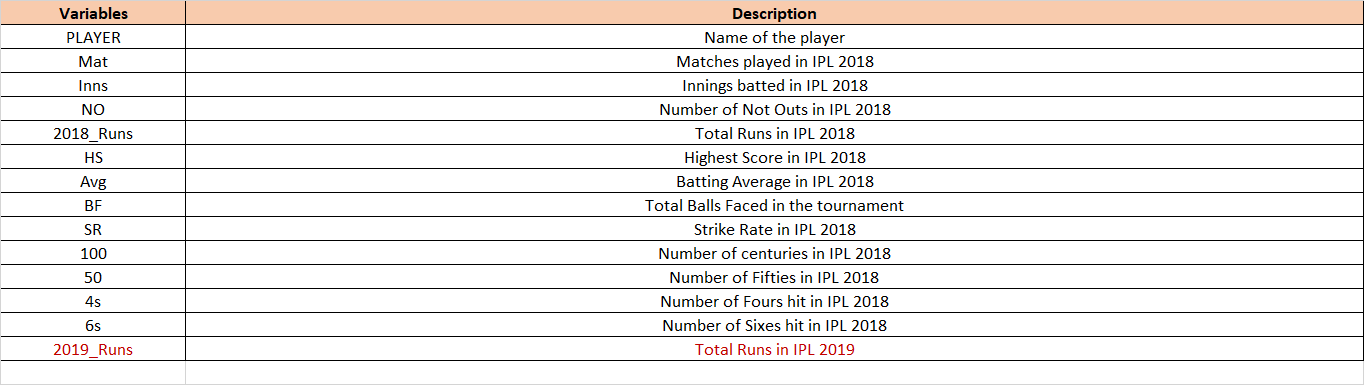 

# Visualizing


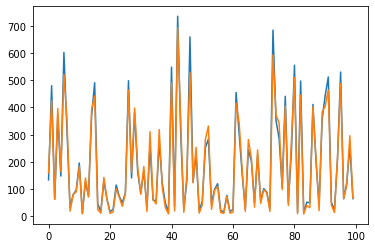

In [201]:
#highly correlated
plt.plot(data['2018_Runs'])
plt.plot(data['2019_Runs'])

<AxesSubplot:>

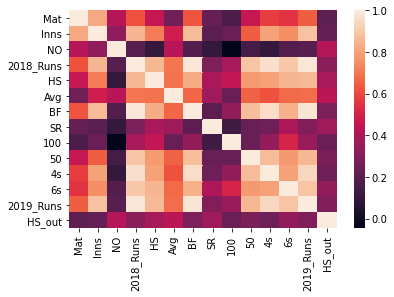

In [202]:
# Corr Heatmap
sns.heatmap(data.corr())  

## Based on correaltion

In [203]:
#HS_out,100,SR,NO are less correlated to 2019
#2018_runs correlated with 4s and BF
# can try removing less correlated features and also 4s and BF
get_results(train_x,train_y,dev_x,dev_y)

Linear Regression :  0.9771795528046363 19.10000975316181 591.2241587809647

Random Forest Regression :  0.9934723878854316 9.198 169.11509000000004

SVM Regression :  0.9909606262653836 8.393083634366457 234.18893093563548

LinearSVR Regression :  0.9615493512040465 23.803193927737613 996.1659512784852

XGBoost Regression :  0.9948413323165801 8.381760311126708 133.6489568083519

Light gbm Regression :  0.9916442007075728 12.021036686218412 216.47912353845246



In [204]:
#including 4s gave better result
#Best score increased from 99.48 to 99.54 (XGBOOST)

get_results(train_x.drop(columns=['HS_out',100,'SR','NO','BF']),train_y,
            dev_x.drop(columns=['HS_out',100,'SR','NO','BF']),dev_y)

Linear Regression :  0.971264457773023 21.074094339449935 744.4703705767408

Random Forest Regression :  0.9918779879688046 10.290500000000002 210.42224500000012

SVM Regression :  0.9919794407932088 8.105954961151747 207.79384073382386

LinearSVR Regression :  0.9529527434308986 20.65381865381068 1218.8838566524776

XGBoost Regression :  0.995434874723956 7.682132816314697 118.27166785790159

Light gbm Regression :  0.9843257734131104 16.459479397601452 406.08237643382853



# Feature Selection

The p-value for each term tests the null hypothesis that the coefficient is equal to zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis. In other words, a predictor that has a low p-value is likely to be a meaningful addition to your model because changes in the predictor's value are related to changes in the response variable.

## OLS

In [208]:
#based on p value of OLS following features are rejected -> 'HS_out','BF','6s','Mat','Avg','4s'
s=sm.OLS(train_y,train_x.drop(columns=['HS_out','BF','6s','Mat','Avg','4s',100,'NO'])).fit()
s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              2019_Runs   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              2182.
Date:                Sun, 18 Oct 2020   Prob (F-statistic):                    1.09e-79
Time:                        20:20:58   Log-Likelihood:                         -358.59
No. Observations:                  80   AIC:                                      727.2
Df Residuals:                      75   BIC:                                      739.1
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inns           4.2544      1.166      3.647      0.000       1.931       6.578
2018_Runs      0.8587      0.054     15.834      0.000       0.751       0.967
HS             0.4820      0.179      2.689      0.009       0.125       0.839
SR            -0.2144      0.058     -3.698      0.000      -0.330      -0.099
50            -8.7229      4.061     -2.148      0.035     -16.813      -0.633
==============================================================================
Omnibus:                        0.321   Durbin-Watson:                   2.306
Prob(Omnibus):                  0.852   Jarque-Bera (JB):                0.158
Skew:                           0.109   Prob(JB):                        0.924
Kurtosis:                       3.010   Cond. No.                         495.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [209]:
get_results(train_x,train_y,dev_x,dev_y)

Linear Regression :  0.9771795528046363 19.10000975316181 591.2241587809647

Random Forest Regression :  0.9915313646741406 10.467999999999995 219.40243999999984

SVM Regression :  0.9909606262653836 8.393083634366457 234.18893093563548

LinearSVR Regression :  0.9291585659778513 25.526392900768457 1835.3350781439217

XGBoost Regression :  0.9948413323165801 8.381760311126708 133.6489568083519

Light gbm Regression :  0.9916442007075728 12.021036686218412 216.47912353845246



In [217]:
#best score inc from 99.48 to 99.55 (Random Forest)
col=['HS_out','BF','6s','Mat','Avg','4s',100,'NO']
get_results(train_x.drop(columns=col),train_y,dev_x.drop(columns=col),dev_y)

Linear Regression :  0.9715228915238822 21.197175658202553 737.7749594112937

Random Forest Regression :  0.9950914278215122 7.179999999999998 127.16956999999998

SVM Regression :  0.9884297308625333 9.81199714911848 299.758483219289

LinearSVR Regression :  0.9455313651502352 26.737584799908895 1411.1543276655107

XGBoost Regression :  0.9935379678500496 9.690408420562743 167.4160672296639

Light gbm Regression :  0.9847002023383085 16.87833829143701 396.38180288992265



## RFE (To be done)

In [398]:
# selector = RFE(xgboost.XGBRegressor(n_estimators=10000), n_features_to_select=6, step=1)
# selector = selector.fit(train_x, train_y)
# r2_score(dev_y,selector.predict(dev_x))

In [399]:
# selector.support_,selector.ranking_

In [400]:
# selector = RFE(RandomForestRegressor(), n_features_to_select=1, step=1)
# selector = selector.fit(train_x, train_y)
# r2_score(dev_y,selector.predict(dev_x))

In [401]:
# RandomForestRegressor()

In [402]:
# train_x.shape

## prediction (ensemble of Random Forest and XGBOOST)

In [377]:
data=pd.read_excel("./Data.xlsx",sheet_name=0)
test_data=pd.read_excel("./Data.xlsx",sheet_name=1)
# data_y=data['2019_Runs']
# data=data.drop(columns=['PLAYER','2019_Runs'])

In [378]:
test_data=test_data=high_score_process(test_data)
data=high_score_process(data)

test_data.columns=[   'PLAYER',       'Mat',      'Inns',        'NO', '2018_Runs',
              'HS',       'Avg',        'BF',        'SR',         100,
                50,        '4s',        '6s',    'HS_out']

In [379]:
    
train_x,dev_x,train_y,dev_y=train_test_split(data.drop(columns=['PLAYER','2019_Runs']),data['2019_Runs'],random_state=1,
                                             test_size=0.2)

In [380]:
col1=['HS_out','BF','6s','Mat','Avg','4s',100,'NO']
# get_results(train_x.drop(columns=col),train_y,dev_x.drop(columns=col),dev_y)

model1=RandomForestRegressor(random_state=3)
model1.fit(train_x.drop(columns=col1),train_y)
model1.score(dev_x.drop(columns=col1),dev_y)

0.9952898435404215

In [381]:
#training on diff train and dev data
train_x,dev_x,train_y,dev_y=train_test_split(data.drop(columns=['PLAYER','2019_Runs']),data['2019_Runs'],random_state=2,
                                             test_size=0.2)

In [382]:
col2=['HS_out',100,'SR','NO','BF']
model2=xgboost.XGBRegressor(n_estimators=10000,random_state=1)
model2.fit(train_x.drop(columns=col2),train_y)
model2.score(dev_x.drop(columns=col2),dev_y)

0.9984349457747841

In [387]:
ans=(model1.predict(test_data.drop(columns=col1+['PLAYER']))+model2.predict(test_data.drop(columns=col2+['PLAYER'])))/2

In [388]:
test_data['Total Runs in IPL 2020']=ans

In [391]:
test_data['Total Runs in IPL 2020']=test_data['Total Runs in IPL 2020'].apply(lambda x : round(x))

In [392]:
test_data

,PLAYER,Mat,Inns,NO,2018_Runs,HS,Avg,BF,SR,100,50,4s,6s,HS_out,Total Runs in IPL 2020
0,David Warner,12,12,2,692,100,69.20,481,143.86,1,8,57,21,1,587
1,KL Rahul,14,14,3,593,100,53.90,438,135.38,1,6,49,25,1,514
2,Quinton de Kock,16,16,1,529,81,35.26,398,132.91,0,4,45,25,0,477
3,Shikhar Dhawan,16,16,1,521,97,34.73,384,135.67,0,5,64,11,1,476
4,Andre Russell,14,13,4,510,80,56.66,249,204.81,0,4,31,52,1,469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Carlos Brathwaite,2,2,0,11,6,5.50,10,110.00,0,0,1,0,0,10
96,Ishant Sharma,13,3,3,10,10,0.00,3,333.33,0,0,1,1,1,10
97,Shakib Al Hasan,3,1,0,9,9,9.00,10,90.00,0,0,0,0,0,10
98,Pawan Negi,7,4,0,9,5,2.25,12,75.00,0,0,1,0,0,9


In [396]:
test_data.loc[:,['PLAYER','Total Runs in IPL 2020']].to_csv("./submission.csv")


## Future Steps
1. Feature Engineering
2. Cross featuring
3. Data Augmentation